# Training an SNN using Neuroevolution!

Featuring Regularization to try reducing silent neurons!!!

In [1]:
import spyx
import spyx.nn as snn

# JAX imports
import os
import jax
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".70"
from jax import numpy as jnp
import numpy as np

from tqdm import tqdm

# implement our SNN in DeepMind's Haiku
import haiku as hk

# optimize the parameters using evosax
import evosax
from evosax.strategies import OpenES as ES
from evosax.strategies import PersistentES as PES

# rendering tools
import matplotlib.pyplot as plt
%matplotlib notebook
import graphviz
import mediapy as media

/home/legion/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/legion/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Data Loading

In [2]:
mnist_dl = spyx.data.MNIST_loader(96)

In [3]:
mnist_dl.train_step().obs.shape

(96, 64, 28, 28, 1)

## SNN

In [4]:
def mnist_snn(x):
    # seqs is [T, F].
    core = hk.DeepRNN([
        hk.Flatten(),
        hk.Linear(300, with_bias=False),
        snn.LIF(300, beta=0.8, activation=spyx.activation.Heaviside()),
        spyx.activation.ActivityRegularization(),
        hk.Linear(100, with_bias=False),
        snn.LIF(100, beta=0.8, activation=spyx.activation.Heaviside()),
        spyx.activation.ActivityRegularization(),
        hk.Linear(10, with_bias=False),
        snn.LI(10, beta=0.9)
    ])
    spikes, V = hk.dynamic_unroll(core, x.astype(jnp.float32), core.initial_state(x.shape[0]), time_major=False, unroll=16)
    return spikes, V

In [5]:
key = jax.random.PRNGKey(0)
SNN = hk.without_apply_rng(hk.transform_with_state(mnist_snn))
params, reg_init = SNN.init(rng=key, x=mnist_dl.train_step().obs)

## Evolution

In [6]:
import optax

@jax.jit
def clipped_l2_spike_count_reg(avg_spike_counts, target_count, radius):
    """
    Spike rate regularization based on clipped mean squared error from target spike count.
    
    Attributes:
        avg_spike_counts: array of average spikes per neuron over a batch.
        target_count: the target number of spikes to be emitted by a neuron
        radius: the tolerance +/- r from the target count where loss is clipped to zero
    
    """

    flat = jnp.concatenate(jax.tree_util.tree_flatten(avg_spike_counts)[0])
    return jnp.sum(jnp.maximum(0,optax.l2_loss(flat, jnp.array([target_count]*flat.shape[0]))/radius - radius))

In [7]:
def evolution(SNN, params, dl, epochs=15, test_every=3, key=0):

    rng = jax.random.PRNGKey(key)
    param_reshaper = evosax.ParameterReshaper(params)
    

    strategy = PES(popsize=256,
                  num_dims=param_reshaper.total_params,
                  opt_name="adam")

    es_params = strategy.default_params
    es_params = es_params.replace(sigma_init=0.1, sigma_decay=0.999, sigma_limit=0.01)
    es_params = es_params.replace(opt_params=es_params.opt_params.replace(
        lrate_init=0.1, lrate_decay=0.999, lrate_limit=0.0005))

    state = strategy.initialize(rng)

    @jax.jit
    def net_eval(individual, events, targets):
        readout, spike_counts = SNN.apply(individual, reg_init, events)
        traces, V = readout
        xe_loss = spyx.loss.integral_crossentropy(traces, targets)
        reg_loss = clipped_l2_spike_count_reg(spike_counts, 24, 8)
        return xe_loss + reg_loss, xe_loss
    
    @jax.jit
    def net_test(individual, events, targets):
        readout, spike_counts = SNN.apply(individual, reg_init, events)
        traces, V = readout
        acc, pred = spyx.loss.integral_accuracy(traces, targets)
        loss = spyx.loss.integral_crossentropy(traces, targets)
        return acc, loss
    
    sim_fn = jax.vmap(net_eval, (0, None, None))
    
    @jax.jit
    def step(rng, state, events, targets):
        rng, rng_ask = jax.random.split(rng, 2)
        # ASK
        pop, state = strategy.ask(rng_ask, state)
        population_params = param_reshaper.reshape(pop.astype(jnp.float32))
        # EVAL
        total_loss, xe_loss = sim_fn(population_params, events, targets) 
        # TELL
        state = strategy.tell(pop, total_loss, state)        
        
        return rng, state, xe_loss
    
    
    for gen in range(epochs):
        pbar = tqdm([*range(dl.train_len//dl.batch_size)])
        pbar.set_description("Epoch #{}".format(gen))
        dl.train_reset()
        for _ in pbar:
            events, targets = dl.train_step() # non-jittable...

            rng, state, loss = step(rng, state, events, targets)
            
            pbar.set_postfix(Loss=jnp.min(loss))
        
        elite = param_reshaper.reshape(jnp.array([state.best_member]))
        elite = jax.tree_util.tree_map(jnp.squeeze, elite)
        if gen % test_every == test_every-1:
            dl.val_reset()
            accs = []
            losses = []
            
            pbar = tqdm([*range(dl.val_len//dl.batch_size)])
            pbar.set_description("Validate")
            for _ in pbar:
                events, targets = dl.val_step()
                
                acc, loss = net_test(elite, events, targets)
                
                accs.append(acc)
                losses.append(loss)
                
                pbar.set_postfix(Loss=np.mean(losses), Accuracy=np.mean(accs))
        
    return jax.tree_util.tree_map(jnp.squeeze, elite)

In [8]:
elite_params = evolution(SNN, params, mnist_dl)

ParameterReshaper: 266200 parameters detected for optimization.


Validate: 100%|██| 187/187 [00:02<00:00, 77.20it/s, Accuracy=0.42, Loss=1.55e+3]


In [38]:
elite_params = evolution(SNN, params, mnist_dl)

ParameterReshaper: 109184 parameters detected for optimization.


Validate: 100%|█████| 187/187 [00:02<00:00, 72.93it/s, Accuracy=0.514, Loss=439]


In [9]:
def plot_readout(data, tgt_label):
    plt.imshow(data.T, aspect="auto")
    plt.title("Readout Activations")
    plt.xlabel("Time")
    plt.ylabel("Class")
    plt.title("Class Label: {}".format(tgt_label))
    plt.colorbar()
    plt.yticks(range(data.shape[-1]))
    plt.show()
    

In [10]:
mnist_dl.train_reset()
sample = mnist_dl.train_step()

In [11]:
sample.obs[0].shape

(64, 28, 28, 1)

In [12]:
elite_params

{'linear': {'w': Array([[ 1.4267987 , -1.204542  ,  0.5638218 , ...,  0.72190464,
          -0.7734895 , -1.4988083 ],
         [ 0.8280027 ,  0.81384087,  0.69781756, ..., -1.664274  ,
          -0.09320844, -0.3265065 ],
         [ 0.1347094 ,  0.5102724 ,  1.2291509 , ...,  0.9461607 ,
          -1.3032095 ,  0.5185031 ],
         ...,
         [ 0.22297058,  0.14896037, -1.5893526 , ..., -0.11270127,
          -0.7476893 ,  1.0472608 ],
         [ 0.6831237 ,  1.0535681 , -0.03002661, ...,  0.8518852 ,
          -0.51443833, -0.3453786 ],
         [ 2.3218133 ,  1.8354889 ,  0.74945074, ..., -0.7565715 ,
          -1.1555436 , -1.5379415 ]], dtype=float32)},
 'linear_1': {'w': Array([[ 1.107  ,  0.0642 , -0.492  , ..., -0.2273 ,  0.5537 , -0.5356 ],
         [ 1.516  , -0.378  ,  2.217  , ..., -0.593  , -1.124  , -0.5425 ],
         [ 0.8164 , -0.7954 ,  0.1432 , ...,  1.013  , -0.05478, -0.2747 ],
         ...,
         [ 1.462  , -0.2283 , -0.5293 , ...,  0.4363 ,  0.9927 , -0.87

In [13]:
readout, spk_cts = SNN.apply(elite_params, reg_init, sample.obs)

In [14]:
spk_cts

{'ActReg': {'spike_count': Array([29.972656 , 23.296143 , 38.93701  , 26.619873 , 18.23413  ,
         20.78711  , 18.932129 , 30.213135 , 17.099731 , 33.666748 ,
         29.83667  , 28.369629 , 37.541504 , 30.77417  , 34.865234 ,
         21.109375 , 13.028687 , 33.49048  , 25.03711  , 27.952148 ,
         33.68701  , 17.901001 , 34.10376  , 39.03076  , 18.682373 ,
         15.142212 , 21.900879 , 14.913086 , 20.963867 , 27.83789  ,
         14.132568 , 22.651367 , 14.299438 , 21.141357 , 19.338135 ,
         11.986938 , 37.364258 , 28.994873 , 30.099121 , 39.88623  ,
         16.505615 , 38.322754 , 23.994629 , 31.66919  , 20.317871 ,
         22.786133 , 21.714111 , 33.05493  , 25.89087  , 22.348389 ,
         12.122314 , 17.921509 , 30.180908 , 28.807373 , 29.358887 ,
         27.610352 , 35.063477 , 31.095459 , 38.21826  , 13.059448 ,
         34.50049  , 32.03418  , 21.495117 , 16.349854 , 30.33789  ,
         15.173828 , 12.966187 , 23.567139 , 22.578613 , 29.723389 ,
         

In [15]:
s, v = readout

In [16]:
s

Array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-8.61718750e+00, -2.74609375e+00, -3.59375000e+00, ...,
         -3.63867188e+00, -5.67382812e-01, -7.93359375e+00],
        ...,
        [-1.69432487e+01,  5.53851585e+01,  3.24972868e-02, ...,
          4.02305641e+01, -2.44530602e+01, -3.96349030e+01],
        [-1.96707993e+01,  5.39911728e+01, -2.99028373e+00, ...,
          4.27309456e+01, -2.39735737e+01, -3.76714134e+01],
        [-2.21177807e+01,  5.39553337e+01, -6.13656807e+00, ...,
          4.49187889e+01, -2.43965282e+01, -3.71405983e+01]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e

In [17]:
jnp.sum(s) # the network is almost entirely silent!!!!!!

Array(33004.332, dtype=float32)

<IPython.core.display.Javascript object>


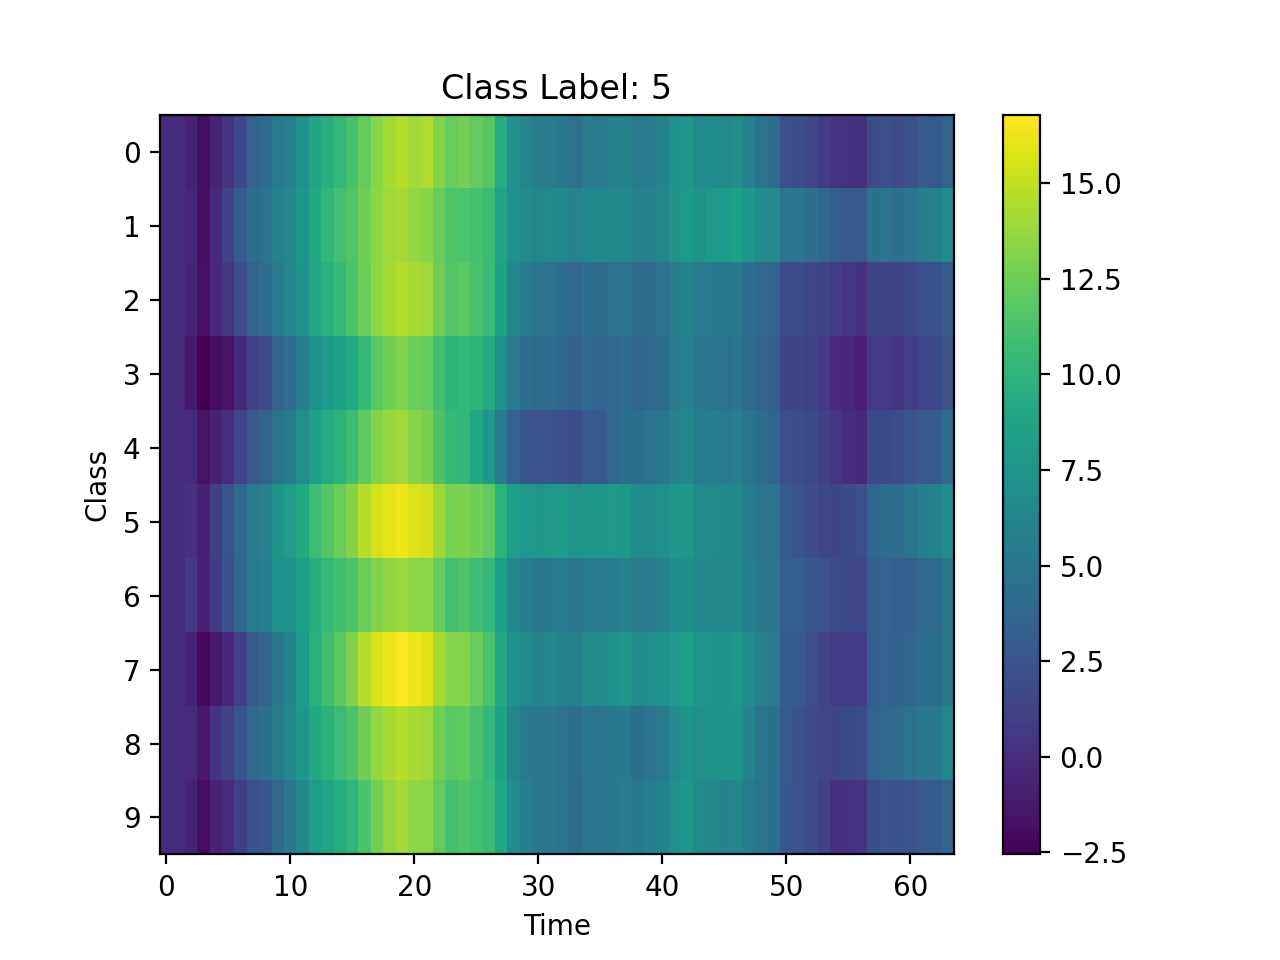

In [48]:
plot_readout(s[0], sample.labels[0])

In [18]:
def test(SNN, in_params, dl):

    @jax.jit
    def net_test(individual, events, targets):
        readout, spike_counts = SNN.apply(individual, reg_init, events)
        traces, V = readout
        acc, pred = spyx.loss.integral_accuracy(traces, targets)
        xe_loss = spyx.loss.integral_crossentropy(traces, targets)
        reg_loss = spyx.loss.mse_spike_count_reg(spike_counts, 16)
        loss = xe_loss + reg_loss
        return acc, loss
    
    dl.test_reset()
    accs = []
    #preds = []
    losses = []
    
    pbar = tqdm([*range(dl.test_len//dl.batch_size)])
    pbar.set_description("Validating")
    for _ in pbar:
        events, targets = dl.test_step()
        
        acc, loss = net_test(in_params, events, targets)
        
        accs.append(acc)
        #preds.append(pred)
        losses.append(loss)
        
        pbar.set_postfix(Loss=np.mean(losses), Accuracy=np.mean(accs))
    
    return accs, losses

In [19]:
acc, losses = test(SNN, elite_params, mnist_dl)

Validating: 100%|█| 104/104 [00:03<00:00, 30.34it/s, Accuracy=0.436, Loss=2.65e+
